In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import display
from PIL import Image
import pathlib
import random
import pickle
import time
import json
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data


In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/APS360/Data/formatted_800x600.pickle")

In [ ]:
LABELS = {
    "red blood cell": 1, 
    "leukocyte": 1, 
    "gametocyte": 0, 
    "trophozoite": 0, 
    "schizont": 0, 
    "ring": 0, 
    "difficult": 0
}

In [ ]:
df.head()

,image,objects,imgpath,imgshape,targets
0,"[[[92, 107, 129], [105, 121, 144], [116, 131, ...","{'boxes': [[tensor(0.9000), tensor(0.8808), te...",/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"[3, 300, 400]","{'boxes': [[tensor(360.), tensor(264.2500), te..."
1,"[[[223, 229, 213], [227, 234, 218], [227, 232,...","{'boxes': [[tensor(0.4594), tensor(0.6117), te...",/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,"[3, 300, 400]","{'boxes': [[tensor(183.7500), tensor(183.5000)..."
2,"[[[228, 228, 236], [230, 230, 238], [229, 229,...","{'boxes': [[tensor(0.6419), tensor(0.6033), te...",/images/6b14c855-8561-417c-97a4-63fa552842fd.png,"[3, 300, 400]","{'boxes': [[tensor(256.7500), tensor(181.), te..."
3,"[[[91, 106, 139], [101, 121, 150], [111, 131, ...","{'boxes': [[tensor(0.8881), tensor(0.4692), te...",/images/13099edb-35d9-438f-b093-2cf2ebf9d255.png,"[3, 300, 400]","{'boxes': [[tensor(355.2500), tensor(140.7500)..."
4,"[[[254, 254, 254], [254, 254, 254], [254, 254,...","{'boxes': [[tensor(0.4300), tensor(0.5150), te...",/images/2559636b-f01a-4414-93da-210c3b12d153.png,"[3, 300, 400]","{'boxes': [[tensor(172.), tensor(154.5000), te..."


In [ ]:
try: df = df.drop(columns=["imgpath", "imgshape"])
except: pass
df.columns

Index(['image', 'objects', 'targets'], dtype='object')

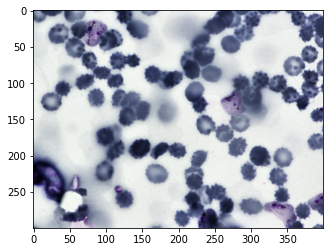

In [ ]:
plt.imshow(df["image"][0])

In [ ]:
class MalariaDataset(Dataset): 
    def __init__(self, df, transform=None): 
        self.df = df
        self.transform = transform

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, index): 
        image = self.df['image'][index]
        targets = self.df['targets'][index]
        if self.transform: 
            image = self.transform(image)
        return image, targets
        
def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(list(images))
    boxes = list(targets)
    return images, targets

def get_loader(df, batch_size=32, transform=None): 
    dataset = MalariaDataset(df, transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [ ]:
data = MalariaDataset(df, transform=transforms.ToTensor())

In [ ]:
np.random.seed(1000)
n = len(df)
n_trn = int(n*0.7)
n_val = int(n*0.2)
train_set, val_set, test_set = torch.utils.data.random_split(dataset=data, lengths=[n_trn, n_val, n-n_trn-n_val])

torch.Size([3, 300, 400])


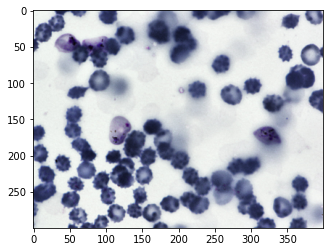

In [ ]:
for i, j in val_set:
  print(i.shape)
  plt.imshow(np.transpose(i.numpy(),(1,2,0)))
  break

In [ ]:
data_dir = pathlib.Path("/content/drive/MyDrive/APS360/Data/Yolo")

In [ ]:
loader1 = DataLoader(train_set, shuffle=False, batch_size=2, collate_fn=collate_fn, drop_last=True)
for i, (img, targets) in enumerate(loader1):
  print(i)
  print(img.shape)
  print(targets)
  break

## Helper Functions

In [ ]:
def show_bound_boxes(image, boxes, labels):
    fig, ax = plt.subplots()
    ax.imshow(image)
    plt.title("Bounding Boxes")
    for box, label in zip(boxes, labels):
        color = "red" if label == 0 else "green"
        width, height = box[2] - box[0], box[3] - box[1]
        bounding_box = patches.Rectangle((box[0], box[1]), width, height ,edgecolor=color, facecolor='none')
        ax.add_patch(bounding_box)

In [ ]:
def to_int(targets):
  boxes = targets['boxes']
  lbls = targets['labels']
  new = lbls.type(torch.LongTensor)
  return {'boxes':boxes, 'labels':new}

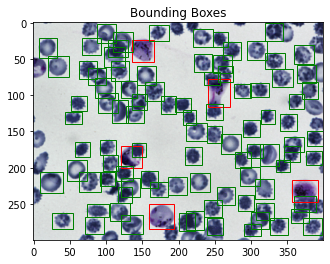

In [ ]:
for i, (img, targets) in enumerate(loader1):
  img = np.transpose(img[0].numpy(), [1,2,0])
  box = targets[0]['boxes']
  lbl = targets[0]['labels']
  show_bound_boxes(img, box, lbl)
  break

## before training

In [ ]:
model1 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=3, pretrained_backbone=True)

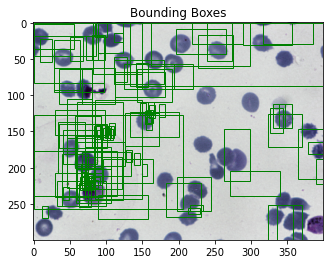

In [ ]:
model1.eval()
for img, targets in loader1:
    pred = model1(img)
    img = np.transpose(img[0].numpy(),[1,2,0])
    box = pred[0]['boxes'].detach()
    lbl = pred[0]['labels'].detach()
    show_bound_boxes(img, box, lbl)
    break

# torchvision api


In [ ]:
model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
features = model2.roi_heads.box_predictor.cls_score.in_features
model2.roi_heads.box_predictor = FastRCNNPredictor(features, 2+1) # 2 classes + background

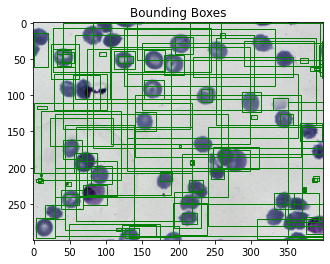

In [ ]:
model2.eval()
for img, targets in loader1:
    pred = model2(img)
    img = np.transpose(img[0].numpy(),[1,2,0])
    box = pred[0]['boxes'].detach()
    lbl = pred[0]['labels'].detach()
    show_bound_boxes(img, box, lbl)
    break

# training

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(features, 2+1)

In [ ]:
# df['targets'] = df['targets'].apply(to_int)

In [ ]:
def train(model, batch_size=2, learning_rate=0.001, step_size=3, epoches = 10):    

    model.train() # train mode
    torch.manual_seed(1000)
    model_path = f"/content/drive/MyDrive/APS360/rcnn/models/torchvision/frcnn_bs{batch_size}_lr{learning_rate}"
    
    train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, collate_fn=collate_fn, drop_last=True)
    val_loader = DataLoader(val_set, shuffle=True, batch_size=batch_size, collate_fn=collate_fn, drop_last=True)
    

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size)
    

    train_loss = np.zeros(epoches)
    val_error = np.zeros(epoches)
    n = len(train_loader)
    batches = int(n/batch_size)

    for epoch in range(epoches):
        epoch_loss = 0 
        for i, (images, targets) in enumerate(train_loader): 
            loss_dict = model(images, targets) # in train mode output is targets
            loss = sum(l for l in loss_dict.values())
 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i==batches-1 or i%15==0:
                print(f'{i}/{batches}')
            epoch_loss += loss.item()
            
        lr_scheduler.step()   # update lr

        train_loss[epoch] = epoch_loss / batch_size
        print(f"Epoch {epoch+1}/{epoches} Loss: {loss.item():.4f}")

        torch.save(model.state_dict(), model_path+f"epoch_{epoch}")

    return model_path

In [ ]:
train(model)

0/232
15/232
30/232
45/232
60/232
75/232
90/232
105/232
120/232
135/232
150/232
165/232
180/232
195/232
210/232
225/232
231/232
240/232
255/232
270/232
285/232
300/232


# yolo

In [ ]:
class basicBlock(nn.Module):
  def __init__(self, in_channel, out_channel, stride=1, downsample=None):
    super(basicBlock, self).__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, stride=stride),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channel, out_channel),
        nn.BatchNorm2d(out_channel),
        )
    self.downsample = downsample

  def forward(self, x):
    x_prev = x
    out = self.layers(x)
    if self.downsample is not None:
      x_prev = self.downsample(x)
    out = F.relu(out + x_prev)
    return out

In [ ]:
class ResNet(nn.Module):
  def __init__(self, layers):
    super(ResNet, self).__init__():

    self.layer1 = Block()

## yo

In [ ]:
class SPP(nn.Module): #spatial pyramid pool
  def __init__(self):
    super().__init__()
    self.pool1 = nn.MaxPool2d(5, stride=1, padding=2),
    self.pool2 = nn.MaxPool2d(9, stride=1, padding=4),
    self.pool3 = nn.MaxPool2d(13, stride=1, padding=6),
    
  def forward(self, x):
    out1 = self.pool1(x)
    out2 = self.pool2(x)
    out3 = self.pool3(x)
    out = torch.cat([x, out1, out2, out3], dim=1)
    return out

class SAM(nn.Module): #spatial attention module
  def __init__(self, in_channels):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, in_channels, 1),
        nn.Sigmoid()
    )
    
  def forward(self, x):
    attention = self.conv(x)
    out = x*attention
    return out

class Bottleneck(nn.Module):
  def __init__(self, in_channels, c1, out_channels):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels, c1, 1),
        nn.BatchNorm2d(c1),
        nn.ReLU(inplace=True),
        nn.Conv2d(c1, out_channels, padding=1, groups=1),
        nn.BatchNorm2d(c1),
        nn.ReLU(inplace=True)
    )
    self.in_channels = in_channels
    self.out_channels = out_channels
  def forward(self, x):
    out = self.layers(x)
    if self.in_channels == self.out_channels:
      out = out + x
    return out

In [ ]:
# from numpy.lib.arraysetops import ediff1d
# from pandas.io.common import get_compression_method
from torchvision.models import resnet
class Yolo(nn.Module):
  def __init__(self, size_in, ):
    super().__init__()
    self.size_in = size_in
    self.grid = self.gt_grid(size_in) #create grid cell
    self.backbone = resnet #pretrained 
    
    self.SPP = SPP()
    self.btn1 = Bottleneck()
    self.SAM = SAM()
    self.btn2 = Bottleneck()
    self.pred = nn.Conv2d()


  def forward(self, x):
    i, j, x = self.backbone(x)
    x = self.SPP(x)
    x = self.btn1(x)
    x = self.SAM(x)
    x = self.btn2(x)

    predict = self.pred(x)
    predict = predict.view(x.shape[0], 1+2+4, -1).permute(0,2,1)
    shape = predict.shape
    pred1 = predict[:,:,1].contiguous().view(shape[0], shape[1], 1)
    pred2 = predict[:,:,1:3].contiguous().view(shape[0], shape[1], 2)
    pred3 = predict[:,:,3:].contiguous().view(shape[0], shape[1], 2)


  def gt_grid(self, size_in, size_cell):
    x, y = size_in
    ranges = [torch.arrange(x/size_cell), torch.arrange(y/size_cell)]
    widths, heights = torch.meshgrid(ranges)
    grid = torch.stack([widths, heights], dim=-1)
    grid = grid.view(1, -1, 2)
    return get_compression_method
  
  def st_grid(self, size_in):
    x, y = size_in
    self.size_in = size_in
    self.grid = self.gt_grid(size_in)
    self.scale = np.array([[y, x, y, x]])
    self.scale_torch = torch.Tensor(self.scale.copy)

  def format_box(self, pred):
    # pred center_x, center_y (as ratios), width, heifht
    # required x1, y1, x2, y2
    c_x, c_y, w, h = pred[0], pred[1], pred[2], pred[3]
    c_x = torch.sigmoid(c_x) + self.grid[:,:,0]
    c_y = torch.sigmoid(c_y) + self.grid[:,:,1]
    w = torch.exp(w)
    h = torch.exp(h)

    x1 = c_x*self.size_cell - w/2
    y1 = c_y*self.size_cell - h/2
    x2 = c_x*self.size_cell + w/2
    y2 = c_y*self.size_cell - h/2

    return [x1, x2, y1, y2]

  def nms(self, boxes, scores, threshold=0.5):
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    areas = (x2-x1)*(y2-y1)
    order = scores.argsort[::-1] #indeices in descending order
    temp = [0]*len(boxes)
    while order.numel()>0:
       i = order[0] # highest score box
       temp.append(boxes[i])
       order = order[1:]
       xx1 = np.maximum(x1[i], x1[order])
       yy1 = np.maximum(y1[i], y1[order])
       xx2 = np.minimum(x2[i], x2[order])
       yy2 = np.minimum(y2[i], y2[order])
       inter = max(0, xx2-xx1)* max(0, yy2-yy1)
       union = areas[i] + areas[order] - inter
       index = np.where(inter/union < threshold)[0]
       order = order[index+1]
    return temp
    
  '''     
  def intersection(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2-x1)* max(0, y2-y1)
    return inter
  '''

In [ ]:
#test

boxes = np.array(
    [[2, 3, 4, 3],
     [1, 2, 3, 4],
     [4, 3, 1, 2]]
)
scores = np.array([1, 3, 2])

def nms(boxes, scores, threshold=0.5):
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    print(x1)
    areas = (x2-x1)*(y2-y1)
    order = scores.argsort()[::-1] #indeices in descending order
    print(order)
    temp = []
    while order.size>0:
       i = order[0] # highest score box
       temp.append(boxes[i])
       print(temp)
       order = order[1:]
       xx1 = np.maximum(x1[i], x1[order])
       
       yy1 = np.maximum(y1[i], y1[order])
       xx2 = np.minimum(x2[i], x2[order])
       yy2 = np.minimum(y2[i], y2[order])
       print(xx1, yy1, xx2, yy2)
       inter = np.maximum(0, xx2-xx1)* np.maximum(0, yy2-yy1)
       print(inter)
       union = areas[i] + areas[order] - inter
       print(union)
       index = np.where(inter/union < threshold)[0]
       print(index)
       order = order[index+1]
    return temp

nms(boxes, scores)

[2 1 4]
[1 2 0]
[array([1, 2, 3, 4])]
[4 2] [3 3] [1 3] [2 3]
[0 0]
[7 4]
[0 1]


IndexError: ignored

In [ ]:
def train():
    Dat

tensor([2., 1., 4.])


TypeError: ignored

In [ ]:
def combine(targets):
  boxes = targets['boxes']
  labels = targets['labels']
  new = []
  for box, label in zip(boxes, labels):
    new.append([label, box[0], box[1], box[2], box[3]])
  return torch.Tensor(new)

# try

In [ ]:
class RCNN(nn.module):
  def __init__(self, num_classes=2):
    super(RCNN, self).__init__()
    self.rpn = RPN()
    self.roi_pool = RoiPool()
    self.encoder = 
    self.fcs = nn.Sequential(
        nn.Linear()
        )
    
  def forward(self, x, targets=None):
    if targets is None:
      out = 
      return out
    else:
      loss = 
      return loss

In [ ]:
resnet = torchvision.models.resnet101(pretrained=True)

In [ ]:
print(resnet)

In [ ]:
class do_nothing(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    return x

In [ ]:
# get rid of last layers
resnet.layer4 = resnet.avgpool = resnet.fc = do_nothing()

class RPN(nn.module):
  def __init__(self, anchor_scales=[32], num_classes=2, encoder=resnet):
    super(RPN, self).__init__()
    type_anchors = len(anchor_scales)
    self.path = "/content/drive/MyDrive/APS360/Models/RPN"
    self.encoder = encoder
    # pixel conv
    self.score = nn.Conv2d(1024, type_anchors*3*2, 1, same_padding=True)
    self.propose = nn.Conv2d(1024, type_anchors*3*4, 1, same_padding=True)
    
  def forward(self, image, targets=None):
    features = self.encoder()
    class_score = self.score(features)
    # softmax
    proposals = self.propose(features)
    # non max suppress
    proposals = self.suppress(proposals)

  def supress(self, boxes, threshold=0.4):
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    areas = (x2-x1)*(y2-y1)
    # IoU = inter/union = inter/(area1+area2-inter)
    
    
  def intersection(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2-x1)* max(0, y2-y1)
    return inter